# Quickstart: Building a Semantic Layer with Data-Tools

This notebook provides a quick introduction to the `intugle` project. You'll learn how to use its key features to automatically build a semantic layer over your data.

**What is a Semantic Layer?**

A semantic layer is a business-friendly representation of your data. It hides the complexity of the underlying data sources and provides a unified view of your data using familiar business terms. This makes it easier for both business users and data teams to understand and query the data, accelerating data-driven insights.

**Who is this for?**

This tool is designed for both **data teams** and **business teams**. 

* **Data teams** can use it to automate data profiling, schema discovery, and documentation, significantly accelerating their workflow.
* **Business teams** can use it to gain a better understanding of their data and to perform self-service analytics without needing to write complex SQL queries.

**In this notebook, you will learn how to:**

1. **Profile your data:** Analyze your data sources to understand their structure, data types, and other characteristics.
2. **Business Glossary Generation:** Generate a business glossary for each column, with support for industry-specific domains.
2. **Automatically predict links:** Use a Large Language Model (LLM) to automatically discover relationships (foreign keys) between tables.
3. **Generate a semantic layer:** Create YAML files file that defines your semantic layer.
4. **Generate SQL queries:** Use the semantic layer to generate SQL queries and retrieve data.

## 1. LLM Configuration

Before running the project, you need to configure a Large Language Model (LLM). This is used for tasks like generating business glossaries and predicting links between tables.

You can configure the LLM by setting the following environment variables:

* `LLM_PROVIDER`: The LLM provider and model to use (e.g., `openai:gpt-3.5-turbo`).
* `OPENAI_API_KEY`: Your API key for the LLM provider.

Here's an example of how to set these variables in your environment:

```bash
export LLM_PROVIDER="openai:gpt-3.5-turbo"
export OPENAI_API_KEY="your-openai-api-key"
```

Alternatively, you can set them in the notebook like this:

In [ ]:
import os

os.environ["LLM_PROVIDER"] = "openai:gpt-3.5-turbo"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key" # Replace with your actual key


## 2. Data Profiling

The first step in building a semantic layer is to profile your data. This involves analyzing your data sources to understand their structure, data types, and other characteristics. The `data-tools` project provides a pipeline for this purpose.


In [18]:
import pandas as pd

from intugle import DataSet

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "Source" shadows an attribute in parent "BaseResource"
  warnings.warn(


In [19]:
# Load the sample data
allergies_df = pd.read_csv('https://raw.githubusercontent.com/Intugle/data-tools/refs/heads/main/sample_data/healthcare/allergies.csv')
allergies_df.head()

,start,stop,patient,encounter,code,system,description,type,category,reaction1,description1,severity1,reaction2,description2,severity2
0,2020-02-17,NaN,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,01efcc52-15d6-51e9-faa2-bee069fcbe44,111088007,Unknown,Latex (substance),allergy,environment,247472004.0,Wheal (finding),MILD,NaN,NaN,NaN
1,2020-02-17,NaN,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,01efcc52-15d6-51e9-faa2-bee069fcbe44,84489001,Unknown,Mold (organism),allergy,environment,76067001.0,Sneezing,MILD,NaN,NaN,NaN
2,2020-02-17,NaN,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,01efcc52-15d6-51e9-faa2-bee069fcbe44,260147004,Unknown,House dust mite (organism),allergy,environment,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-17,NaN,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,01efcc52-15d6-51e9-faa2-bee069fcbe44,264287008,Unknown,Animal dander (substance),allergy,environment,878820003.0,Rhinoconjunctivitis (disorder),MODERATE,271807003.0,Eruption of skin (disorder),MILD
4,2020-02-17,NaN,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,01efcc52-15d6-51e9-faa2-bee069fcbe44,256277009,Unknown,Grass pollen (substance),allergy,environment,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Create a DataSet object and run the profiling pipeline
dataset_allergies = DataSet(allergies_df, "allergies")
dataset_allergies.run(domain="Healthcare")

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[!] Empty column encountered for allergies ==> stop ...
100%|██████████| 15/15 [00:20<00:00,  1.34s/it]


,column_name,business_name,table_name,null_count,count,distinct_count,uniqueness,completeness,sample_data,dtype_sample,ts,datatype_l1,datatype_l2,business_glossary,business_tags
0,start,start,allergies,0,794,179,0.225441,1.0,"[2004-09-28, 1954-08-25, 1993-03-10, 2015-01-2...","[2020-02-17, 1981-05-17, 1960-01-05, 1960-05-2...",0.009269,date & time,L2OutputTypes.dimension,Indicates the initial date and time when an al...,"[Allergy Onset Date, Patient Medical History, ..."
1,stop,stop,allergies,794,794,0,0.000000,0.0,[],[],0.000883,others,L2OutputTypes.unknown,Indicates the conclusion or cessation of a spe...,"[EndDate, AllergyResolution, InactiveStatus]"
2,patient,patient,allergies,0,794,179,0.225441,1.0,"[d3e4ad8c-11f2-14cf-28be-e4400b6caff1, ce54be4...","[b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85, 0288c42...",0.008875,alphanumeric,L2OutputTypes.dimension,Identifies individuals associated with recorde...,"[Patient Identifier, Healthcare Record Linkage..."
3,encounter,encounter,allergies,0,794,179,0.225441,1.0,"[42fb21d3-b631-9722-b8b2-58756e071049, c677fed...","[01efcc52-15d6-51e9-faa2-bee069fcbe44, 79de99b...",0.009535,alphanumeric,L2OutputTypes.dimension,A unique identifier associated with a specific...,"[Patient Encounter, Clinical Visit Tracking, H..."
4,code,code,allergies,0,794,21,0.026448,1.0,"[3718001, 735971005, 25037, 29046, 84489001, 5...","[111088007, 84489001, 260147004, 264287008, 25...",0.010052,integer,L2OutputTypes.dimension,Identifies specific types of allergic reaction...,"[Allergy Identifier, Medical Classification, H..."


The `run()` method performs a series of analysis steps, including:

* **Profiling:** Calculates statistics for each column, such as distinct count, uniqueness, and completeness.
* **Datatype Identification:** Identifies the data type of each column (e.g., integer, string, datetime).
* **Key Identification:** Identifies potential primary keys.
* **Glossary Generation:** Generates a business glossary for each column using an LLM.

> The `domain` parameter helps the LLM generate a more contextual business glossary. It specifies the industry domain that the dataset belongs to (e.g., "Healthcare", "Finance", "E-commerce").


## 3. Automated Link Prediction

Now that we've profiled our data, let's discover the relationships between tables. The `data-tools` project uses a LLM to predict links (foreign keys) between tables.

First, we'll load a few more tables from the sample dataset.

In [ ]:
table_names = ["patients", "claims", "careplans", "claims_transactions", "medications"]
datasets = [dataset_allergies]


def generate_table_url(table_name: str) -> str:
    """Append the base URL to the table name."""
    return f"https://raw.githubusercontent.com/Intugle/data-tools/refs/heads/main/sample_data/healthcare/{table_name}.csv"


for table_name in table_names:
    table_url = generate_table_url(table_name)
    df = pd.read_csv(table_url)
    dataset = DataSet(df, table_name)
    dataset.run(domain="Healthcare")
    datasets.append(dataset)

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 52%|█████▏    | 13/25 [00:06<00:05,  2.05it/s][!] Error while llm response parsing: Got invalid JSON object. Error: Expecting ',' delimiter: line 2 column 27 (char 28)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
 64%|██████▍   | 16/25 [00:08<00:04,  2.10it/s][!] Error while llm response parsing: Got invalid JSON object. Error: Expecting ',' delimiter: line 2 column 27 (char 28)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
[*] patients:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael

Now, let's run the link prediction pipeline.

In [22]:
from intugle import LinkPredictor

# Initialize the predictor
predictor = LinkPredictor(datasets)

# Run the prediction
results = predictor.predict()
results.links

Dataset 'allergies' is missing key identification. Running prerequisite analysis...


/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[!] Empty column encountered for allergies ==> stop ...
100%|██████████| 15/15 [00:06<00:00,  2.60it/s][!] Error while llm response parsing: Got invalid JSON object. Error: Expecting ',' delimiter: line 2 column 27 (char 28)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
100%|██████████| 15/15 [00:07<00:00,  2.10it/s]

Dataset 'patients' already processed. Skipping analysis.
Dataset 'claims' already processed. Skipping analysis.
Dataset 'careplans' already processed. Skipping analysis.
Dataset 'claims_transactions' already processed. Skipping analysis.
Dataset 'medications' is missing key identification. Running prerequisite analysis...



/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 13/13 [00:08<00:00,  1.53it/s]


LinkPredictor initialized with datasets: ['allergies', 'patients', 'claims', 'careplans', 'claims_transactions', 'medications']

--- Comparing 'allergies' <=> 'patients' ---


[*] allergies <==> patients Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 potential link(s).

--- Comparing 'allergies' <=> 'claims' ---


[*] allergies <==> claims Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'careplans' ---


[*] allergies <==> careplans Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'claims_transactions' ---


[*] allergies <==> claims_transactions Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'medications' ---


[*] allergies <==> medications Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


No links found for this pair.

--- Comparing 'patients' <=> 'claims' ---


[*] patients <==> claims Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


Found 1 potential link(s).

--- Comparing 'patients' <=> 'careplans' ---


[*] patients <==> careplans Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Found 1 potential link(s).

--- Comparing 'patients' <=> 'claims_transactions' ---


[*] patients <==> claims_transactions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Found 1 potential link(s).

--- Comparing 'patients' <=> 'medications' ---


[*] patients <==> medications Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Found 1 potential link(s).

--- Comparing 'claims' <=> 'careplans' ---


[*] claims <==> careplans Runs:1: 100%|██████████| 1/1 [00:10<00:00, 10.48s/it]


No links found for this pair.

--- Comparing 'claims' <=> 'claims_transactions' ---


[*] claims <==> claims_transactions Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.00s/it]


Found 1 potential link(s).

--- Comparing 'claims' <=> 'medications' ---


[*] claims <==> medications Runs:1: 100%|██████████| 1/1 [00:17<00:00, 17.98s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'claims_transactions' ---


[*] careplans <==> claims_transactions Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.82s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'medications' ---


[*] careplans <==> medications Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Found 1 potential link(s).

--- Comparing 'claims_transactions' <=> 'medications' ---


[*] claims_transactions <==> medications Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

No links found for this pair.


[PredictedLink(from_dataset='allergies', from_column='patient', to_dataset='patients', to_column='id'),
 PredictedLink(from_dataset='patients', from_column='id', to_dataset='claims', to_column='patientid'),
 PredictedLink(from_dataset='patients', from_column='id', to_dataset='careplans', to_column='patient'),
 PredictedLink(from_dataset='patients', from_column='id', to_dataset='claims_transactions', to_column='patientid'),
 PredictedLink(from_dataset='patients', from_column='id', to_dataset='medications', to_column='patient'),
 PredictedLink(from_dataset='claims', from_column='id', to_dataset='claims_transactions', to_column='claimid'),
 PredictedLink(from_dataset='careplans', from_column='encounter', to_dataset='medications', to_column='encounter')]

The `results` object contains the predicted links between the tables. You can also visualize the relationships as a graph.


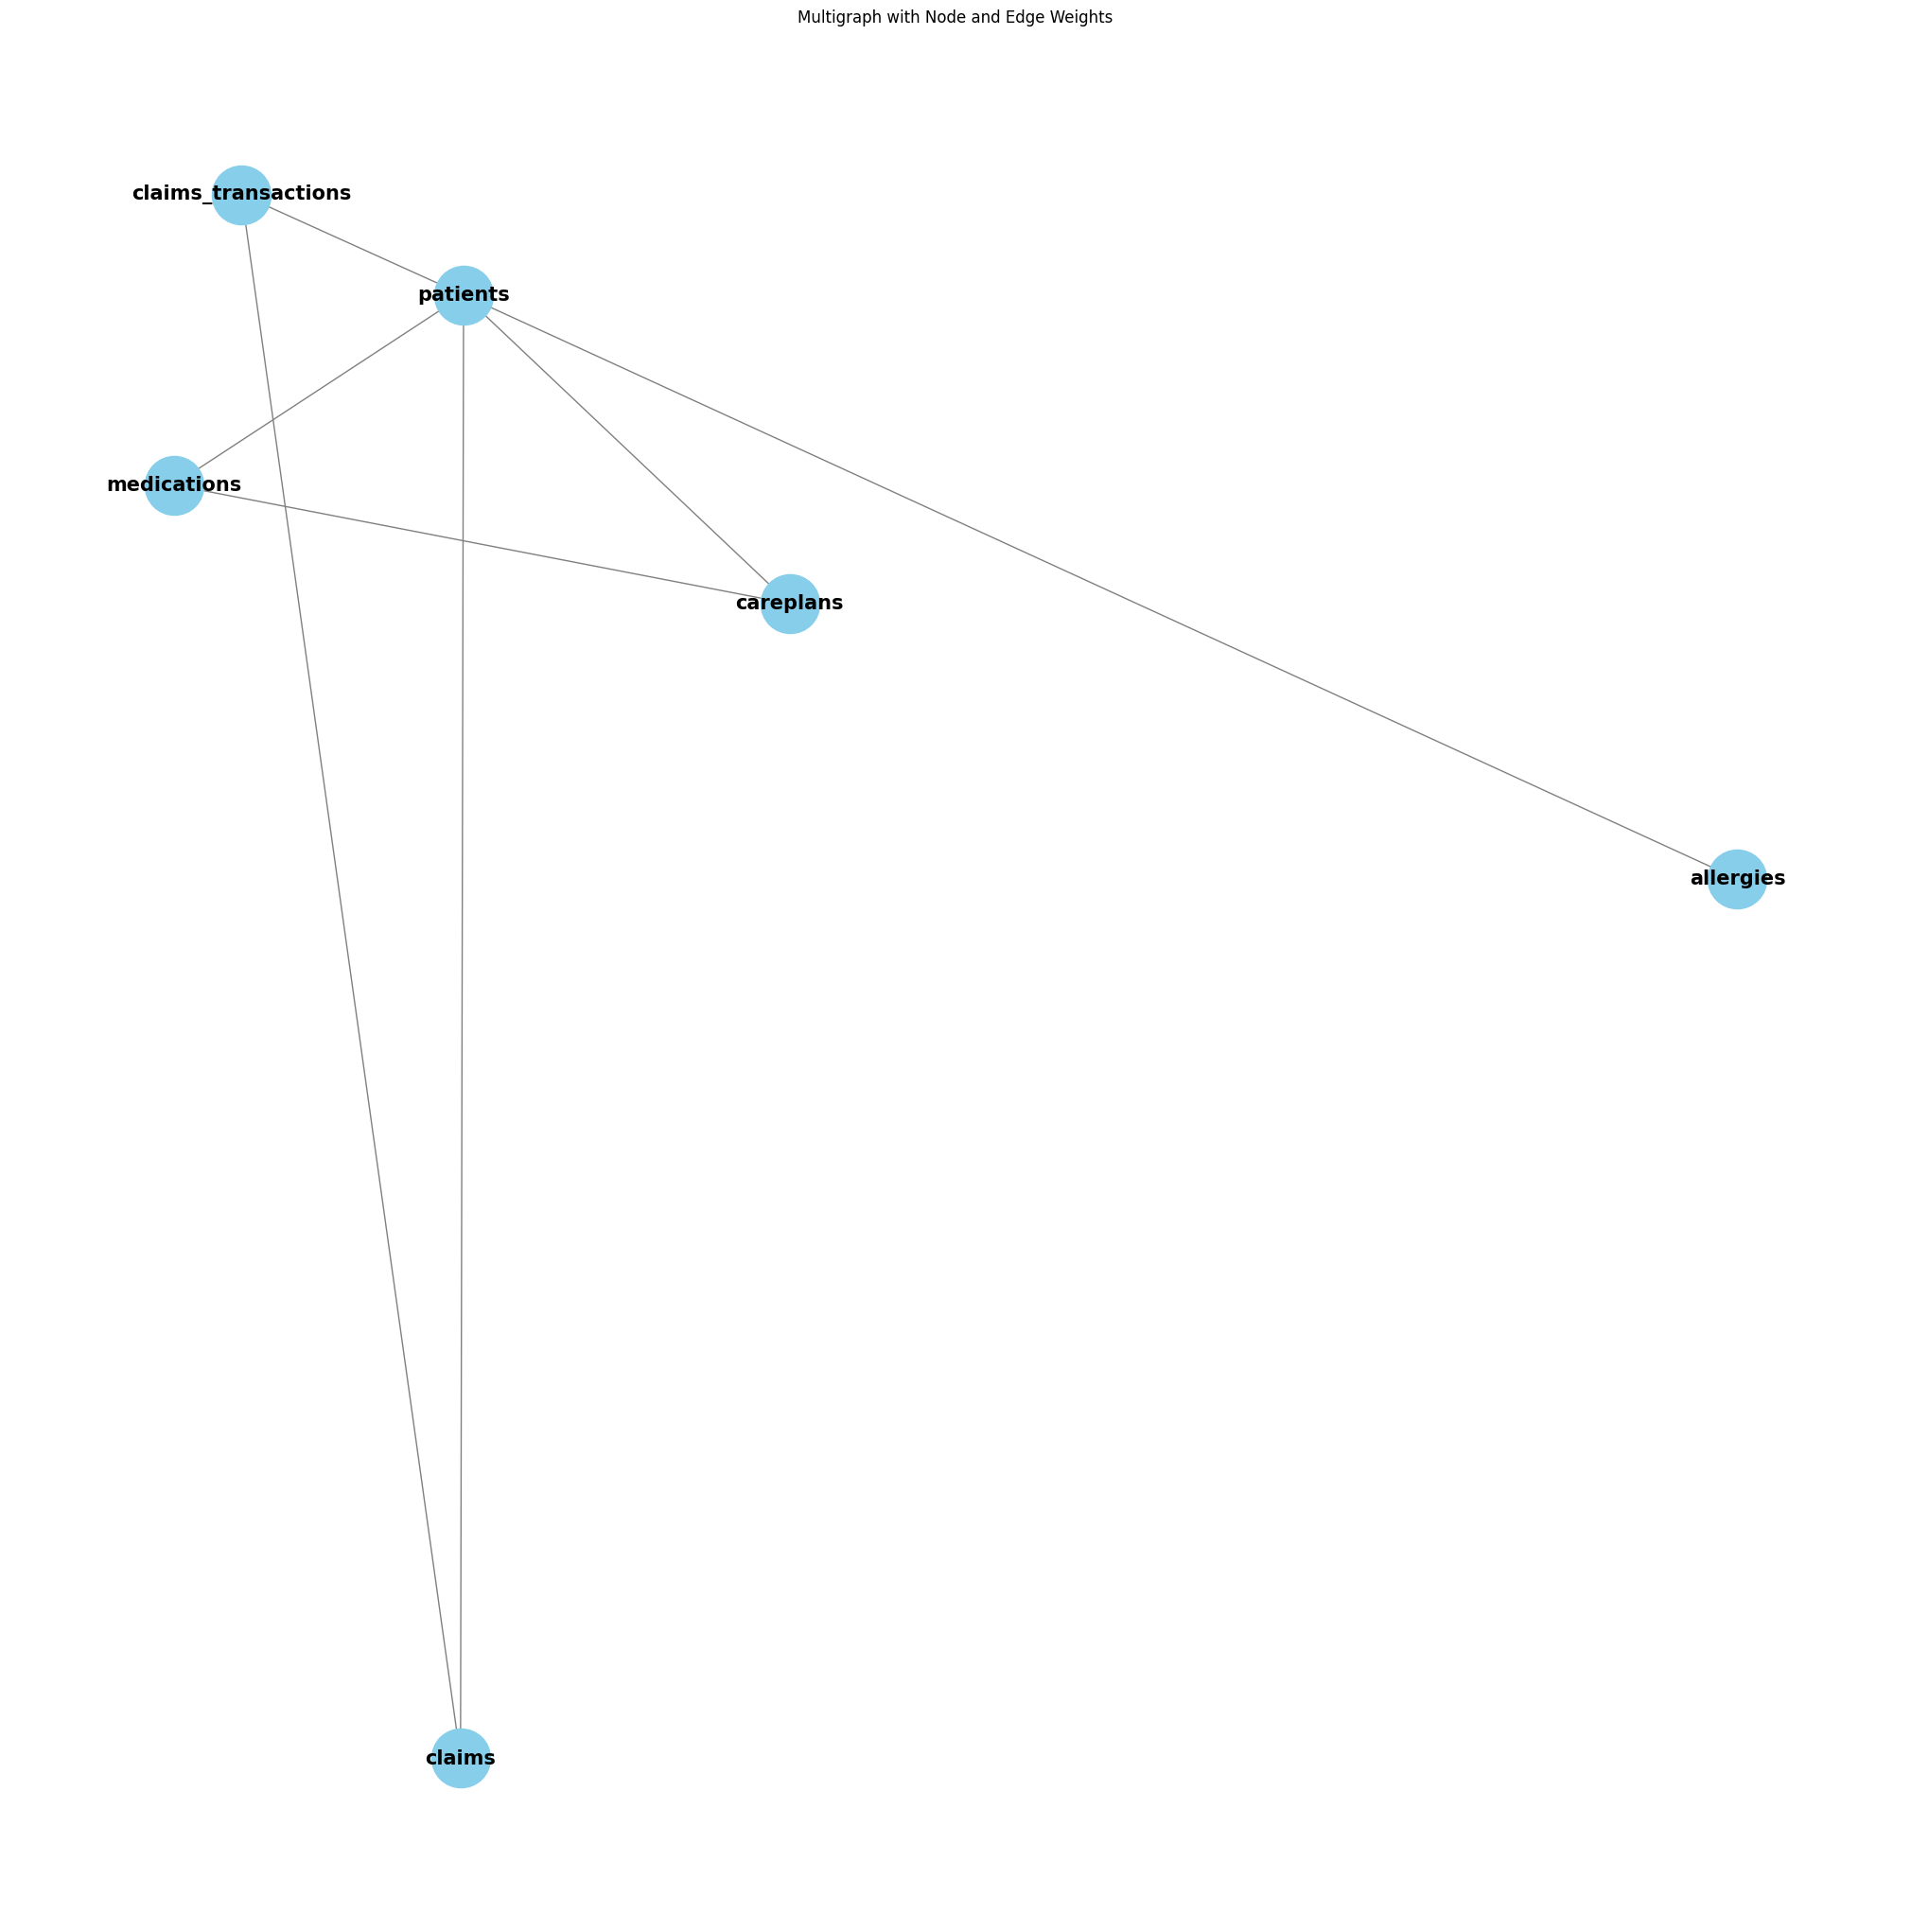

In [23]:
results.show_graph()


## 4. The Semantic Layer (Manifest)

The profiling and link prediction results are used to generate YAML files which are saved automatically. These files defines the semantic layer, including the models (tables) and their relationships. 

By default, these files are saved in the current working directory. You can configure this path by setting the `PROJECT_BASE` environment variable. They can also be saved manually as shown below:

In [24]:
for ds in datasets:
    ds.save_yaml()

results.save_yaml("relationships.yml")

Now, we can load the YAML files and create a manifest.

## 5. SQL Generation

Once you have a semantic layer, you can use the `SqlGenerator` to generate SQL queries. This allows you to query the data using business-friendly terms, without having to write complex SQL.

Let's create an ETL model to define the query we want to generate.

In [25]:

etl = {
    "name": "test_etl",
    "fields": [
        {"id": "patients.first", "name": "first_name"},
        {"id": "patients.last", "name": "last_name"},
        {"id": "allergies.start", "name": "start_date"},
    ],
    "filter": {
        "selections": [{"id": "claims.departmentid", "values": ["3", "20"]}],
    },
}

Now, let's use the `SqlGenerator` to generate the SQL query.

In [26]:
from intugle.sql_generator import SqlGenerator

# Create a SqlGenerator
sql_generator = SqlGenerator()

# Generate the query
sql_query = sql_generator.generate_query(etl)

# Print the query
print(sql_query)

SELECT patients.first as `first_name`, patients.last as `last_name`, allergies.start as `start_date` FROM `claims` LEFT JOIN `patients` ON patients.id = claims.patientid LEFT JOIN `allergies` ON allergies.patient = patients.id WHERE (claims.departmentid IN '['3', '20']')


## Conclusion

This notebook has provided a brief overview of the `data-tools` project. You've learned how to:

* Configure your LLM provider.
* Profile your data to understand its characteristics.
* Use an LLM to automatically predict links between tables.
* Generate a semantic layer.
* Use the semantic layer to generate SQL queries.

This is just a starting point. The `data-tools` project has many other features to explore. We encourage you to try it with your own data and see how it can help you build a powerful semantic layer.
